In [2]:
from __future__ import absolute_import, unicode_literals, print_function
import numpy as np
from numpy import pi, cos
import pymultinest as pys
import corner
import numpy as np
import pylab as plt
from scipy.linalg import logm
import corner
import scipy.stats as stat
from matplotlib.patches import Ellipse
from matplotlib.collections import PatchCollection
import copy as COPY
import pandas as pd
plt.style.use('classic')

%matplotlib inline

#%matplotlib nbagg

In [3]:
npix = 200
noise_level = 1
Sources = 		pd.read_csv("/home/hope-moloko/Masters/Masters_Project/source_list1_new.csv")
steps = 5

In [4]:
Sources

,Unnamed: 0,X,Y,R,A
0,0,169.977348,69.707159,4,9.112498


Text(0,0.5,'Y Position')

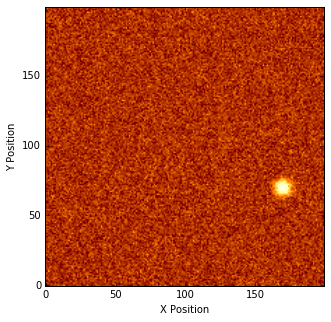

In [5]:
#################### Circularly Gaussian shaped  function ##################
def tau(x,y,X,Y,R,A):  #Circularly  Gaussian Shaped function
    term1 = ((x-X)**2 + (y-Y)**2)/(2*R**2)
    return A*np.exp(-term1)

########################### Source Image ###############################################
x = np.arange(0, npix, 1, float)
y = x [:,np.newaxis]

source1_template = np.zeros((npix,npix))
for i in range(len(Sources)):

    X_true = Sources['X'][i]
    Y_true = Sources['Y'][i]
    R_true = Sources['R'][i]
    A_true = Sources['A'][i]

    source1_template += tau(x,y,X_true,Y_true,R_true,A_true) 



# ADD noise level

noise = 	np.random.normal(0,noise_level,source1_template.shape)
Source = 	source1_template  + noise


plt.figure(figsize=(5,7))
plt.imshow(Source,origin='lower',cmap='afmhot',)
plt.xlabel('X Position')
plt.ylabel('Y Position')

In [9]:
def Model(x,y,Xm,Ym,Rm,Am):  #Model that describes each source
    x = np.arange(0, npix, 1, float)
    y = x[:,np.newaxis]
 
    source_template = tau(x,y,Xm,Ym,Rm,Am) #+tau(x,y,X1m,Y1m,R1m,A1m)
    return source_template


def logLike(cube): #Likelihood function
    Xm = cube[0]
    Ym = cube[1]
    Rm = 4     #fixed Spatial extent
    Am = 3     #fixed amplitude

   # X1m = cube[2]
   # Y1m = cube[3]
    #R1m = 4    #fixed Spatial extent
   # A1m = 6    #fixed amplitude
    data = Source
    mu = Model(x,y,Xm,Ym,Rm,Am)
    LogL = -(len(data)/2)*np.log(2*np.pi)-(len(data)/2)*np.log(3**2)-(1/(2*(3**2)))*(np.sum((data-mu)**2))
    
    return LogL 

def mypriors():
    x = npix*np.random.random()
    y = npix*np.random.random()
    #r = 7*np.random.random()

    #x1 = npix*np.random.random()
    #y1 = npix*np.random.random()
    #r1 = 7*np.random.random()
    #a = 5*np.random.random()+1
    return np.array([x,y]) #,x1,y1])

def plus(x,y):
    if x>y:
        return x+np.log(1+np.exp(y-x))
    
    else:
        return y+np.log(1+np.exp(x-y))

In [10]:
def propose_point(new,scale):
    new_point = new + scale*np.random.uniform()
    return new_point

def prior_transform(u):
    x = npix*u[0]
    y = npix*u[1]
    
    '''x1 = npix*u[2]
    y1 = npix*u[3]'''
    return np.array([x,y]) #,x1,y1])

In [11]:
###################Sample N pionts from prior##########################
n = 500  # Number of live points
objects = np.zeros((n,2))
l_objects = np.zeros((n))
active_u = np.random.random(2)
for i in range(n):
    #objects[i,:] = mypriors()
    objects[i,:] = prior_transform(active_u)
    l_objects[i] = logLike(cube = objects[i,:])


In [12]:
nest = 50000
keep = np.zeros((nest,2))
logl_sample = []     #Store Log-likelihood of samples
X_sample = []        #Store prior mass
   

mcmc_steps = 10
logWT = []  #Store  weight =width*likelihood


logZ = -1e300     # SUM(weights)= Z Evidence
H = 0

X = 0          # Unit prior mass (Xo = 1)


In [33]:
## MAIN NS LOOP##

#Outer interval 
logw = np.log(1.0 - np.exp(-1.0 / n))

for i in range(nest):
    # Draw worst object with L* from n points
    worst = np.argmin(l_objects)
    
    #Save worst opbject
    keep[i,:] = objects[worst,:]
    logl_sample.append(l_objects[worst])
    
    #Save prior mass
    X_sample.append(logw)
    
    #Weight
    logwt = logw + l_objects[worst]
    
    
    #Save weight
    logWT.append(logwt)
    
    #Update Evidence Z
    logZnew = plus(logZ,logwt)  
    
    #Update H information
    H = np.exp(logwt-logZnew)*l_objects[worst] \
    +np.exp(logZ-logZnew)*(H+logZ)-logZnew
    
    #Update logZ
    logZ = logZnew
    #Shrink interval
    logw -= 1.0/n 
   

    while True:#----copy a random point and do mcmc from there-----
        copy = np.random.randint(len(objects))
        if (copy != worst):break
            
    objects[worst,:] = COPY.deepcopy(objects[copy,:])
    Likelihood_thresh =  l_objects[copy]
    theta = objects[copy,:]
    sigma = [2.5,2.2,2.5,2.2]                 #[4,5,3,2]
    interval = [0,npix]
    
    
    scale = 1.
    accept = 0
    reject = 0
    ncall = 0
    while ncall<steps:  #Evolve within current worst likelihood L>L* , draw new point under constraint
        
        new_u = propose_point(active_u,scale)
        new_point = prior_transform(new_u)
        #Accpt = 0
        '''for j in range(4):
            
            if (interval[0]<= new_point[j] <= interval[1]):
                Accpt += 1
        
        if Accpt == 4:
            prior = 1
        else: 
            prior = 0'''
        
        Likelihood_new = logLike(new_point)*prior
        
       
        if Likelihood_thresh<=Likelihood_new:
            objects[worst,:] = new_point  #Replace worst point with new point
            l_objects[worst] = Likelihood_new   #Replace the worst likelihood with new one 
            active_u = new_u
            accept += 1
        else:
            reject += 1
        
        #rescale
        if accept > reject:
            scale *= np.exp(1. / accept)
        if accept < reject:
            scale /= np.exp(1. / reject)

        ncall += 1

                
    if i >nest*np.exp(H)/np.log(2.):
        break
        

Z = logZ
Z_err = np.sqrt((H)/n)
H = H        #np.exp(H)/np.log(2.)
print('Evidence Z = {0} +-{1} : Information H = {2} '.format(Z,Z_err,H))

Evidence Z = -1.0000000000000142 +-0.044721359549996106 : Information H = 1.0000000000000142 


In [34]:

#Normalized samples
wt = np.exp((logWT)-max(logWT))
Weights = wt/sum(wt)

#prob_weighted = [(logWT[i]+logl_sample[i])/Z for i in range(nest)]  # CHANGED Logx_same to logWT

prob = prob_weighted/sum(prob_weighted)

#Effective sample size
#effective_sample_size = int(np.exp(-np.sum(prob*np.log(prob))))
effective_sample_size = int(np.exp(-np.sum(Weights*np.log(Weights+1e-300))))
S = 0
sample = np.zeros((effective_sample_size,4))

# Selecting the Effective sample
while True:
    rnd_point = np.random.randint(len(keep))
    #proba = prob_weighted[rnd_point]/max(prob_weighted)
    proba = Weights[rnd_point]/max(Weights)
    
    if np.random.rand() < proba:
        sample[S,:] = keep[rnd_point,:]
        S += 1
    if S >= effective_sample_size:
        break
print('Effective Sample Size : {}'.format(effective_sample_size))

NameError: name 'prob_weighted' is not defined

In [302]:
X_true = Sources['X'][0]
X1_true = Sources['X'][1]

Y_true = Sources['Y'][0]
Y1_true = Sources['Y'][1]

In [303]:
X,X_err,X1,X1_err = np.mean(sample[:,0]),np.std(sample[:,0]),np.mean(sample[:,2]),np.std(sample[:,2])
Y,Y_err,Y1,Y1_err = np.mean(sample[:,1]),np.std(sample[:,1]),np.mean(sample[:,3]),np.std(sample[:,3])
print('X: {:.3f}-+{:.3f}  X1: {:.3f}-+{:.3f}'.format(X,X_err,X1,X1_err),"|",'X_true : {} X1_true: {}'.format(X_true,X1_true))
print()
print('Y: {:.3f}-+{:.3f}  Y1: {:.3f}-+{:.3f}'.format(Y,Y_err,Y1,Y1_err),"|",'Y_true: {} Y1_true: {}'.format(Y_true,Y1_true))

X: 109.235-+60.838  X1: 61.131-+76.168 | X_true : 140.41891023829177 X1_true: 190.87363545200336

Y: 104.505-+65.825  Y1: 137.784-+72.341 | Y_true: 88.845236398063 Y1_true: 46.47525842869915


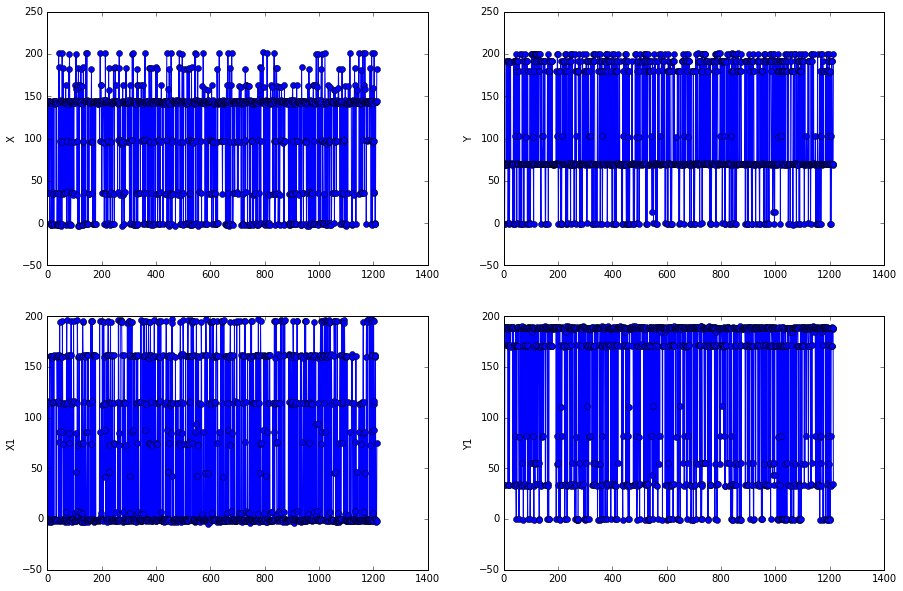

In [304]:
plt.figure(figsize=(15,10))

labels = ['X','Y','X1','Y1']
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.plot(sample[:,i],'-o')
    plt.ylabel(labels[i])
    


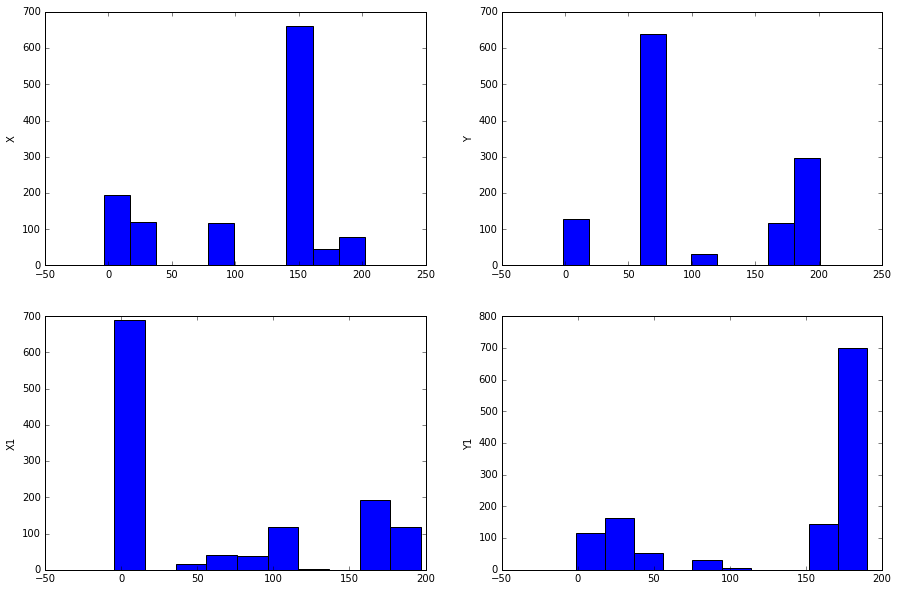

In [298]:
plt.figure(figsize=(15,10))

labels = ['X','Y','X1','Y1']
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.hist(sample[:,i])
    plt.ylabel(labels[i])
    


## Trace plots

The two trace plots in each row correspond to a single source with Position X,Y.

#### -  From the trace plots on the left column for the x positons, it can be seen that there is a clear convergence (i.e finding an x position of one source) but at some point there's a jump from one mode to the other and back again??

#### - The same result can be seen on the right column of the Y positions.
    

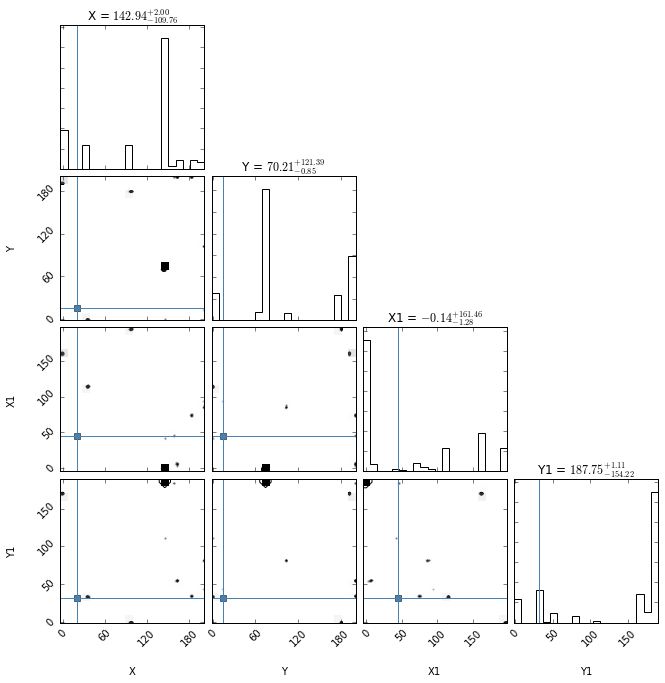

In [296]:
corner.corner(sample,labels=['X','Y','X1','Y1'],show_titles=True,bins=20,levels=[0.5,0.65],truths=[20,15,45,32]);


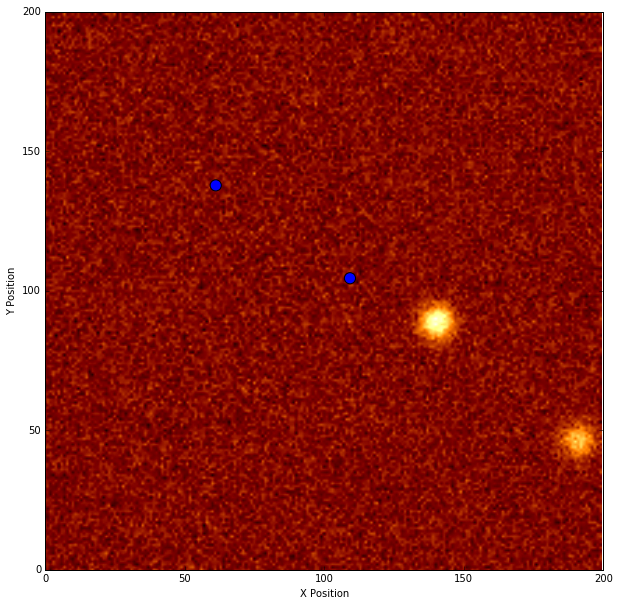

In [297]:
plt.figure(figsize=(10,15))
ax = plt.gca()
ellipses = []
plt.xlim([0,npix])
plt.ylim([0,npix])
X_pos = [X,X1]
Y_pos = [Y,Y1]
for ra, dec in zip(X_pos,Y_pos):
    ellipse = Ellipse(xy=(ra, dec), width=4, height=4, angle=0)
    ellipses.append(ellipse)

p = PatchCollection(ellipses)
ax.add_collection(p)
plt.imshow(Source,origin='lower',cmap='afmhot',)
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.show()

## The circles in blue are the estimated positions X,Y of the sources.